In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import cv2
from keras.models import load_model
from sklearn import svm
from sklearn.svm import SVC

In [2]:
print(keras.__version__)

3.0.5


In [3]:
model = keras.saving.load_model(os.path.join('models', 'SequentialRelu50epochs1500resample64size.keras'))

In [4]:
dataset = pd.read_csv('project_dataset/HAM10000_metadata.csv')
SIZE = 64

In [5]:
labEnc = LabelEncoder()
labEnc.fit(dataset['dx'])
LabelEncoder()

dataset['label'] = labEnc.transform(dataset["dx"])
dataset.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
8801,HAM_0004399,ISIC_0028905,nv,histo,20.0,female,face,5
2243,HAM_0004898,ISIC_0029480,mel,histo,55.0,female,lower extremity,4
7736,HAM_0006567,ISIC_0033439,nv,histo,30.0,female,back,5
5904,HAM_0000387,ISIC_0031826,nv,follow_up,25.0,female,trunk,5
2350,HAM_0000494,ISIC_0032745,vasc,histo,55.0,male,lower extremity,6
8077,HAM_0001136,ISIC_0031848,nv,histo,40.0,male,chest,5
2590,HAM_0002565,ISIC_0032660,bcc,histo,75.0,male,back,1
5836,HAM_0002850,ISIC_0024638,nv,follow_up,45.0,male,lower extremity,5
3564,HAM_0005598,ISIC_0029023,nv,follow_up,45.0,male,abdomen,5
7931,HAM_0000468,ISIC_0028591,nv,histo,5.0,female,lower extremity,5


In [6]:
# Read images based on the image ID from the csv file
image_path = {os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join('all_images/', '*.jpg'))}

In [7]:
# Define the path and add as a new column
dataset['path'] = dataset['image_id'].map(image_path.get)

#use the path to read images, then convert them to 224,224 then add them to a new column called image
dataset['image'] = dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [8]:
# Concert dataframe image attributes into a numpy array
XF = np.asarray(dataset['image'].tolist())
# Scale values between 0-1 by dividing by the highest possible value (255)
XF = XF/255
# assign label values (what we are trying to predict) to Y, label is used instead of dx because label is an integer and the computer won't understand dx
YF = dataset['label']
# Convert to categorical as this is multiclass classification
YF_cat = to_categorical(YF,num_classes = 7)
# make training and testing partitions
# x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [9]:
yf_pred = model.predict(XF)

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step


In [10]:
yf_pred_maxes = []
for row in yf_pred:
    yf_pred_maxes.append(row.argmax())

In [11]:
yf_maxes = []
for row in YF_cat:
    yf_maxes.append(row.argmax())

In [12]:
from sklearn.metrics import classification_report

print(classification_report(yf_maxes,yf_pred_maxes))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       327
           1       0.66      0.88      0.75       514
           2       0.49      0.79      0.60      1099
           3       0.56      0.99      0.72       115
           4       0.40      0.79      0.53      1113
           5       0.97      0.66      0.79      6705
           6       0.76      0.99      0.86       142

    accuracy                           0.72     10015
   macro avg       0.66      0.85      0.72     10015
weighted avg       0.83      0.72      0.74     10015


In [13]:
cm = confusion_matrix(yf_maxes, yf_pred_maxes)

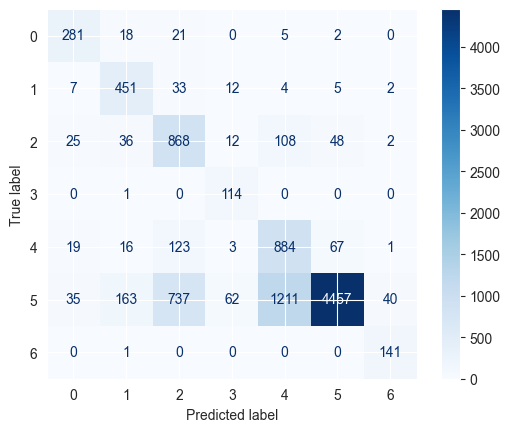

In [14]:
from sklearn import metrics
labels = np.unique(YF)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

cm_display.plot(cmap='Blues')
plt.show()
#https://www.w3schools.com/python/python_ml_confusion_matrix.asp